In [48]:
import pandas as pd
import numpy as np
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols

# Cointegration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Reporting visualization
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import itertools


In [23]:
symbols = get_nasdaq_symbols()
symbols = symbols[(symbols["ETF"] == True) & (symbols["Market Category"] == "G")] # G = NASDAQ GLOBAL MARKET
symbols = list(symbols.index.values)
data = pdr.get_data_yahoo(symbols,"2017-01-01","2023-01-01")["Adj Close"]



[*********************100%%**********************]  596 of 596 completed


111 Failed downloads:
['TXSS', 'FINE', 'DFGX', 'LGRO', 'BLCR', 'HQGO', 'MKAM', 'DGCB', 'CANC', 'UFIV', 'GPIQ', 'BSMW', 'HRTS', 'UNIY', 'MEDX', 'SMCO', 'BSVO', 'BDGS', 'JIVE', 'BEEZ', 'JTEK', 'ETEC', 'NVDU', 'UTWY', 'FDFF', 'JGLO', 'ROE', 'BUFC', 'NVDD', 'TDI', 'MAGS', 'TSLT', 'GSIB', 'PTEC', 'TMET', 'WISE', 'CPLS', 'SMRI', 'AIRL', 'SPAM', 'UTHY', 'BKWO', 'BSCX', 'XBIL', 'IBTO', 'FDTX', 'WABF', 'AUMI', 'BKIV', 'RUNN', 'VGSR', 'FDCF', 'QYLE', 'USRD', 'AMDS', 'XFIX', 'BSJV', 'CZAR', 'WTBN', 'USVN', 'PRVT', 'SFLO', 'SMCF', 'LITP', 'USCL', 'CALY', 'TSDD', 'FDIV', 'VPLS', 'DYNI', 'DFGP', 'GPIX', 'VCRB', 'TSLR', 'COPJ', 'FEPI', 'CA', 'UTRE', 'FDIF', 'BSSX', 'CHPS', 'FBOT', 'CLOA', 'USFI', 'IBOT', 'VFLO', 'PSWD', 'TSLZ', 'CAFG', 'NVD', 'SPAQ', 'NSI', 'COWS', 'EYEG', 'UPGR', 'BRTR', 'USCF', 'QOWZ', 'NIKL', 'ABCS', 'HCOW', 'ILIT', 'DYTA', 'JPEF', 'URNJ', 'JDOC', 'QQQY', 'SETM', 'FMED', 'ICOP', 'CLOD']: Exception("%ticker%: Data doesn't exist for startDate = 1483246800, endDate = 1672549200")


In [26]:
data.dropna(axis=1, inplace=True)
display("Shape:", data.shape)
display("Null Values:", data.isnull().values.any())
display(data.head())

'Shape:'

(1510, 259)

'Null Values:'

False

,AADR,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIRR,ALTY,ANGL,...,VTHR,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WOOD,XT
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,38.378620,48.610233,52.050152,33.607414,14.57545,14.884954,40.685703,23.451801,8.726160,20.394279,...,92.506104,39.782997,106.655449,49.565144,91.095413,55.973511,37.490700,42.702915,47.666119,25.109814
2017-01-04,39.039192,49.092213,52.495316,33.980915,14.57545,14.918926,40.903088,23.797688,8.848814,20.457827,...,93.569305,39.799179,108.894714,50.308537,92.473625,56.196556,37.904465,43.135921,48.091225,25.436159
2017-01-05,39.457874,49.784519,52.696083,34.271416,14.57545,14.915846,41.407425,23.393663,8.914820,20.507240,...,93.399551,39.847736,108.056190,49.806862,91.227074,56.556263,38.188423,43.553978,48.055805,25.520079
2017-01-06,39.327621,49.539143,52.704811,34.130318,14.57545,14.903491,41.233509,23.393663,9.000677,20.528421,...,93.640747,39.782997,107.503525,49.597065,90.735451,56.398003,38.107307,43.322552,48.055805,25.566696
2017-01-09,39.467178,49.582966,52.582615,34.080521,14.57545,14.866418,41.346550,22.900963,8.942854,20.542536,...,93.319115,39.807270,107.436813,49.264145,89.638130,56.541885,38.034283,43.203121,47.745815,25.629169


# Data Preprocessing

In [27]:
df_returns = pd.DataFrame(data.pct_change().mean() * 255, columns=["Returns"])
df_returns["Volatility"] = data.pct_change().std() * np.sqrt(255)
df_returns.head()

,Returns,Volatility
AADR,0.063471,0.232683
AAXJ,0.067744,0.214246
ACWI,0.097429,0.189566
ACWX,0.063804,0.187475
AGNG,0.116228,0.189890


In [29]:
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
df_scaled = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index)
df_scaled.head()

,Returns,Volatility
AADR,-0.246648,0.227599
AAXJ,-0.184409,0.040618
ACWI,0.247893,-0.209677
ACWX,-0.241789,-0.230880
AGNG,0.521668,-0.206387


In [30]:
K = range(1, 15)
distortions = [KMeans(n_clusters=k).fit(df_scaled).inertia_ for k in K]
kl = KneeLocator(K, distortions, curve="convex", direction="decreasing")
c = kl.elbow

In [32]:
k_means = KMeans(n_clusters=c).fit(df_scaled)
clustered_series = pd.Series(index=df_scaled.index, data=k_means.labels_.flatten())

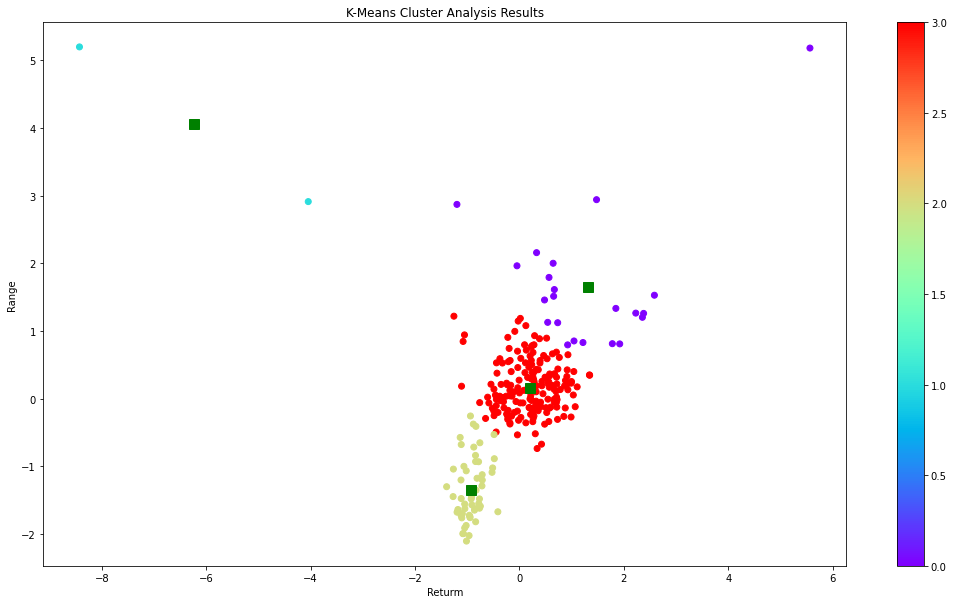

In [46]:
import matplotlib.pyplot as plt


centroids = k_means.cluster_centers_


fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(111)
scatter = ax.scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], c=k_means.labels_, cmap="rainbow")
ax.set_title("K-Means Cluster Analysis Results")
ax.set_xlabel("Returm")  # Update with the actual feature name
ax.set_ylabel("Range") # Update with the actual feature name
plt.colorbar(scatter)

# Plotting the centroids
plt.plot(centroids[:, 0], centroids[:, 1], "sg", markersize=10)

# Display the plot
plt.show()


In [51]:
# Calculate cointegration
# Function to check cointegration
def check_cointegration(asset1, asset2):
    score, p_value, _ = coint(data[asset1], data[asset2])
    return p_value < 0.05

# Find cointegrated pairs within each cluster
cointegrated_pairs = []
clusters = clustered_series.unique()  # Assuming clustered_series is a Series mapping assets to cluster labels

for cluster in clusters:
    assets_in_cluster = clustered_series[clustered_series == cluster].index
    for asset1, asset2 in itertools.combinations(assets_in_cluster, 2):
        if check_cointegration(asset1, asset2):
            cointegrated_pairs.append({"base_asset": asset1, "compare_asset": asset2, "label": cluster})

df_coint = pd.DataFrame(cointegrated_pairs)


In [52]:
df_coint

,base_asset,compare_asset,label
0,AADR,BOTZ,3
1,AADR,DAX,3
2,AADR,FCA,3
3,AADR,IMOM,3
4,AADR,PIE,3
...,...,...,...
664,FTXL,SOXX,0
665,ICLN,QMOM,0
666,QCLN,QMOM,0
667,QCLN,SMH,0


['AADR' 'AAXJ' 'ACWI' 'ACWX' 'AGNG']


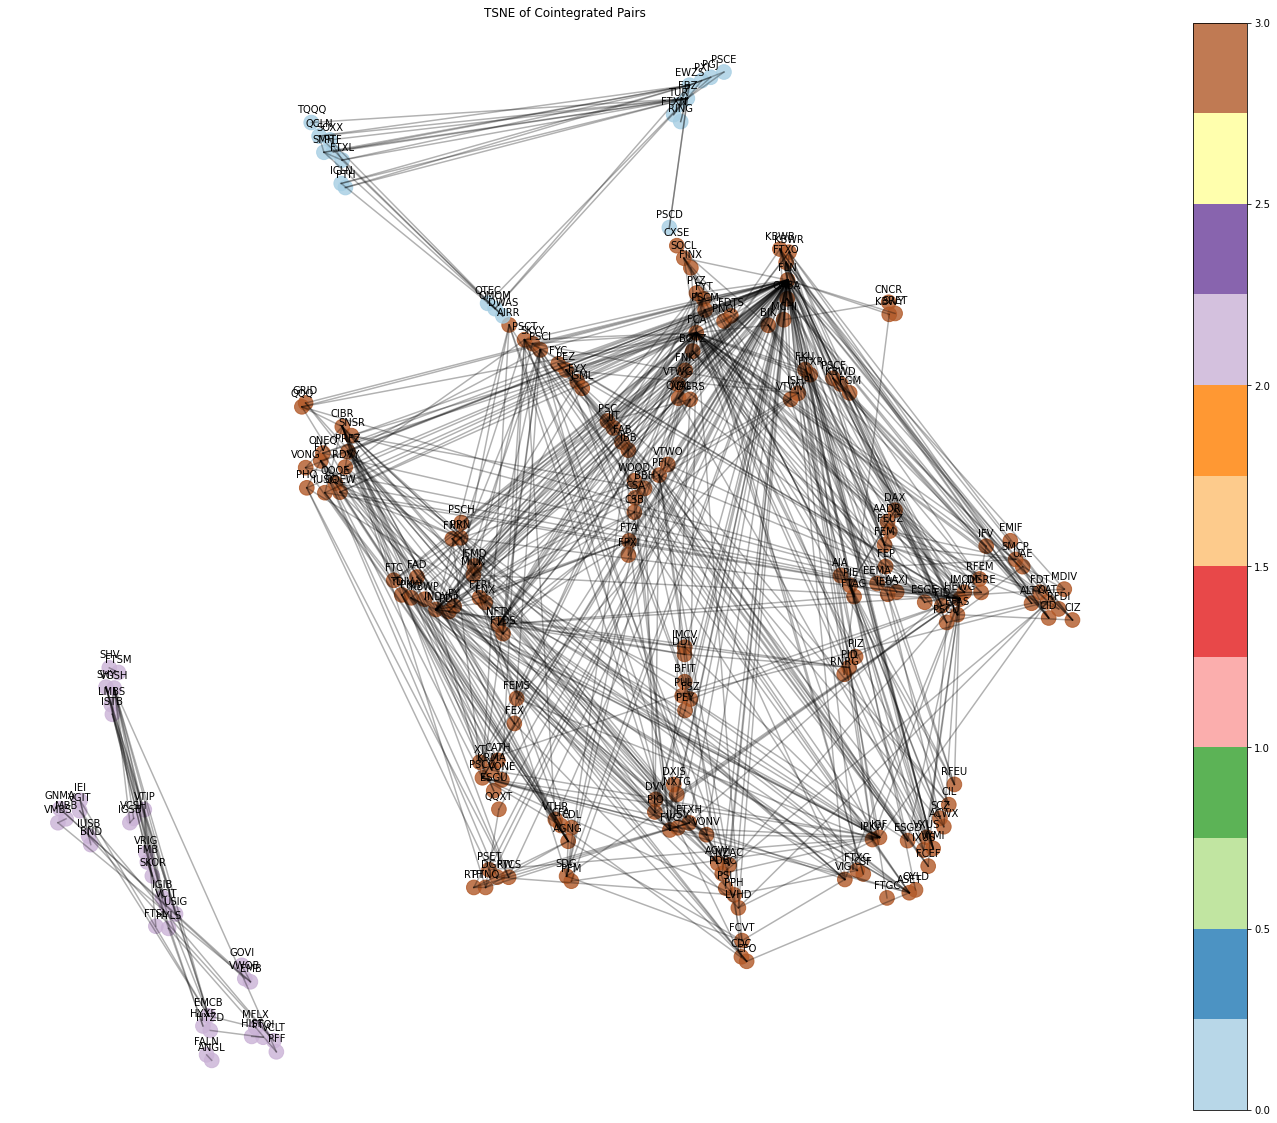

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE

coint_assets = np.unique(np.concatenate([df_coint["base_asset"], df_coint["compare_asset"]]))


# Preparing DataFrame for t-SNE
df_TSNE = df_scaled.loc[coint_assets]
X_tsne = TSNE(learning_rate=30, perplexity=5, random_state=42, n_jobs=-1).fit_transform(df_TSNE)

# Mapping assets to their cluster labels
in_pairs_series = clustered_series.loc[coint_assets]

plt.figure(figsize=(25, 20))
plt.axis('off')

# Connecting lines for cointegrated pairs
for index, pair in df_coint.iterrows():
    loc1, loc2 = df_TSNE.index.get_loc(pair["base_asset"]), df_TSNE.index.get_loc(pair["compare_asset"])
    x1, y1 = X_tsne[loc1]
    x2, y2 = X_tsne[loc2]
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3)


scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=215, alpha=0.8, c=in_pairs_series.values, cmap=cm.Paired)
plt.colorbar(scatter)
plt.title('TSNE of Cointegrated Pairs')

# Annotating points with asset names
for x, y, name in zip(X_tsne[:, 0], X_tsne[:, 1], df_TSNE.index):
    plt.annotate(name, (x, y), textcoords="offset points", xytext=(0,10), ha="center")

plt.show()


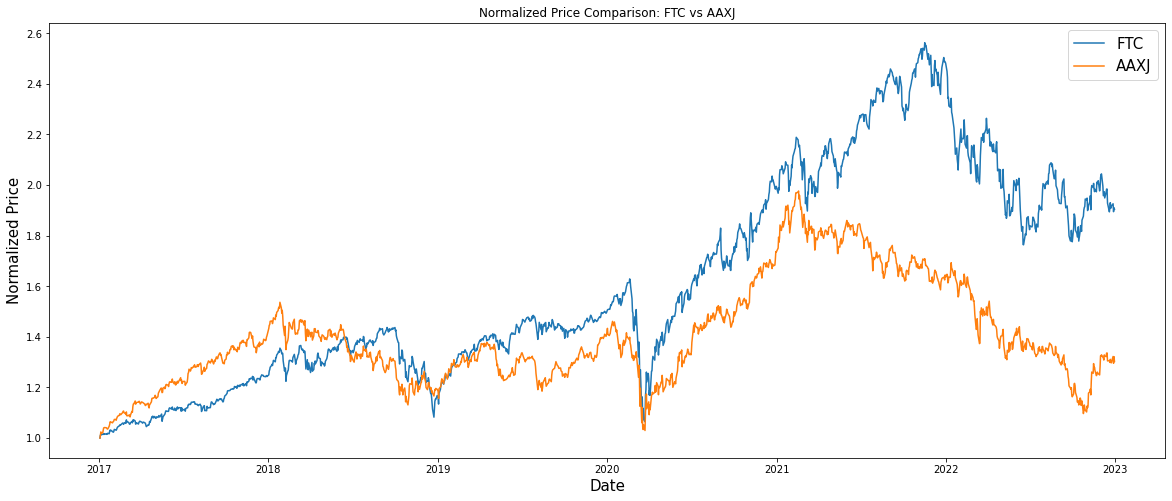

In [65]:
import matplotlib.pyplot as plt

# Function to normalize and plot asset values
def plot_normalized_asset_prices(data, asset_1, asset_2):
    if asset_1 not in data.columns or asset_2 not in data.columns:
        raise ValueError(f"One or both assets not found in data: {asset_1}, {asset_2}")

    asset_1_values = data[asset_1] / data[asset_1].iloc[0]
    asset_2_values = data[asset_2] / data[asset_2].iloc[0]

    plt.figure(figsize=(20, 8))
    plt.plot(data.index, asset_1_values, label=asset_1)
    plt.plot(data.index, asset_2_values, label=asset_2)

    plt.title(f"Normalized Price Comparison: {asset_1} vs {asset_2}")
    plt.xlabel("Date",fontsize=15)
    plt.ylabel("Normalized Price", fontsize=15)
    plt.legend(fontsize=15)

    plt.show()

# Example usage
asset_1 = "FTC"
asset_2 = 'AAXJ'
plot_normalized_asset_prices(data, asset_1, asset_2)
